In [1]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import math
import re
import matplotlib.pyplot as plt
import statsmodels.datasets as ds
import pymc as mc
from mpl_toolkits.basemap import Basemap
%matplotlib inline

## MCMCを使った事後分布サンプリングからのベイズモデルの当てはめ

データ読み込み

In [2]:
df = pd.read_csv("Allstorms.ibtracs_wmo.v03r05.csv", delim_whitespace=False)
df

,Serial_Num,Season,Num,Basin,Sub_basin,Name,ISO_time,Nature,Latitude,Longitude,Wind(WMO),Pres(WMO),Center,Wind(WMO) Percentile,Pres(WMO) Percentile,Track_type
0,1848011S09080,1848,2,SI,MM,XXXX848003,1848-01-11 06:00:00,NR,-8.60,79.80,0,0,reunion,-100.000,-100.000,main
1,1848011S09080,1848,2,SI,MM,XXXX848003,1848-01-12 06:00:00,NR,-9.00,78.90,0,0,reunion,-100.000,-100.000,main
2,1848011S09080,1848,2,SI,MM,XXXX848003,1848-01-13 06:00:00,NR,-10.40,73.20,0,0,reunion,-100.000,-100.000,main
3,1848011S09080,1848,2,SI,MM,XXXX848003,1848-01-14 06:00:00,NR,-12.80,69.90,0,0,reunion,-100.000,-100.000,main
4,1848011S09080,1848,2,SI,MM,XXXX848003,1848-01-15 06:00:00,NR,-13.90,68.90,0,0,reunion,-100.000,-100.000,main
5,1848011S09080,1848,2,SI,MM,XXXX848003,1848-01-16 06:00:00,NR,-15.30,67.70,0,0,reunion,-100.000,-100.000,main
6,1848011S09080,1848,2,SI,MM,XXXX848003,1848-01-17 06:00:00,NR,-16.50,67.00,0,0,reunion,-100.000,-100.000,main
7,1848011S09080,1848,2,SI,MM,XXXX848003,1848-01-18 06:00:00,NR,-18.00,67.40,0,0,reunion,-100.000,-100.000,main
8,1848011S09080,1848,2,SI,MM,XXXX848003,1848-01-19 06:00:00,NR,-20.60,69.80,0,0,reunion,-100.000,-100.000,main
9,1848011S09080,1848,2,SI,MM,XXXX848003,1848-01-20 06:00:00,NR,-22.80,72.00,0,0,reunion,-100.000,-100.000,main


年ごとの発生個数をリスト化する

In [3]:
cnt_na = df[df["Basin"] == " NA"].groupby("Season")["Serial_Num"].nunique() #北大西洋で発生した台風の個数
cnt_wp = df[df["Basin"] == " WP"].groupby("Season")["Serial_Num"].nunique() #西太平洋で発生した台風の個数

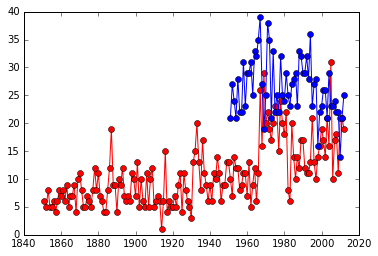

In [4]:
years = cnt_na.index
y0, y1 = years[0], years[-1]
ary_na = cnt_na.values
ary_wp = cnt_wp.values
plt.plot(years, ary_na, '-or')
plt.plot(cnt_wp.index, ary_wp, '-ob')

どっかのタイミングで変化が生じたとする(技術革新か気候変動か)

In [5]:
sw_pnt = mc.DiscreteUniform("sw pnt", lower = 0, upper=len(ary_na))
early_mean = mc.Exponential("early mean", beta = 1)
late_mean = mc.Exponential("late mean", beta = 1)

適当な値を返す関数を生成する．

In [6]:
@mc.deterministic(plot=False) # 関数を変数に？
def rate(s=sw_pnt, e=early_mean, l=late_mean):
    out = np.empty(len(ary_na))
    out[:s] = e
    out[s:] = l
    return out

In [7]:
storms = mc.Poisson("storms", mu=rate, value=ary_na, observed=True)

In [8]:
model = mc.Model([sw_pnt, early_mean, late_mean, rate, storms])
mcmc = mc.MCMC(model)
mcmc.sample(iter=10000, burn=1000, thin=10)

 [-----------------100%-----------------] 10000 of 10000 complete in 1.3 sec

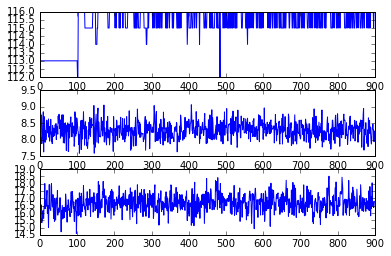

In [9]:
plt.subplot(311)
plt.plot(mcmc.trace("sw pnt")[:])
plt.subplot(312)
plt.plot(mcmc.trace("early mean")[:])
plt.subplot(313)
plt.plot(mcmc.trace("late mean")[:])

(array([   2.,    3.,   12.,   20.,   56.,   81.,  130.,  157.,  163.,
         109.,   87.,   41.,   19.,   16.,    4.]),
 array([ 14.59582624,  14.85722291,  15.11861959,  15.38001626,
         15.64141293,  15.9028096 ,  16.16420627,  16.42560294,
         16.68699962,  16.94839629,  17.20979296,  17.47118963,
         17.7325863 ,  17.99398297,  18.25537965,  18.51677632]),
 <a list of 15 Patch objects>)

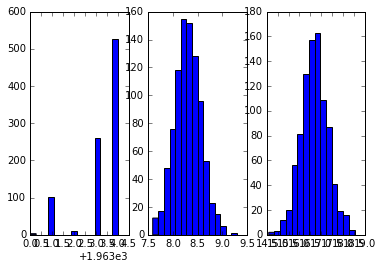

In [10]:
plt.subplot(131)
plt.hist(mcmc.trace("sw pnt")[:] + years[0], 15)
plt.subplot(132)
plt.hist(mcmc.trace("early mean")[:], 15)
plt.subplot(133)
plt.hist(mcmc.trace("late mean")[:], 15)

In [11]:
yp = years[0] + mcmc.trace("sw pnt")[:].mean()
em = mcmc.trace("early mean")[:].mean()
lm = mcmc.trace("late mean")[:].mean()
print([yp, em, lm])

[1966.3399999999999, 8.2942627073437549, 16.668448007377162]


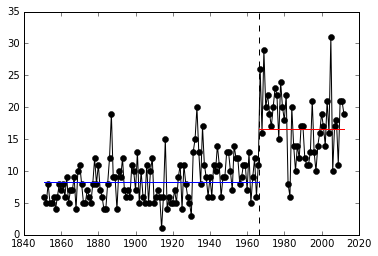

In [12]:
plt.plot(years, ary_na, '-ok')
plt.axvline(yp, color='k', ls='--')
plt.plot([years[0], yp], [em, em], '-b')
plt.plot([yp, years[-1]], [lm, lm], '-r')